In [1]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics, cross_validation
import time

## Function to lookup team_id given team_abbreviation

### Input paramters:

tm_dict  --> dictionary with team_ids and team_abbreviations, one id can have multiple abbreviations

team_abv --> team abbreviation

### Output:

key --> team id

In [2]:
def lookup_team_id(tm_dict,team_abv):
    for key,values in tm_dict.items():
        for value in values:
            if value == team_abv:
                return key

## Function to get X, y data of a team against its opponent team for logistic regression.

### Input parameters:

dframe    --> dataframe with all the data

teamID    --> team id of the team you want the data for

oppTeamID --> team id of the opponent team you want the data for

### Outputs:

X --> feature matrix

y --> outcome vector, win (1) or loss (0) in this case

In [3]:
def prepare_data(dframe, teamID, oppTeamID):
    data_all_teamID = dframe.loc[dframe['TEAM_ID'] == teamID].loc[dframe['OPPONENT_ID'] == oppTeamID]
    X = data_all_teamID[['WL','FGM','FGA','FG3M','FG3A','FTM','FTA','OREB','DREB','AST','STL','BLK','TOV','PF']].copy()
    y = X['WL'].copy()
    # set the first column of X to be an intercept column and set its value to 1
    X['WL'] = 1 # intercept column
    rnd_indx = np.random.permutation(y.index.size)
    X = np.array(X.iloc[rnd_indx])
    y = np.array(y.iloc[rnd_indx])
    return X, y

In [4]:
#start_time = time.time()

# List of teams available:
#
# [ ATL, BOS, CLE, NOH, CHI, DAL, DEN, GOS, HOU, LAC, LAL, MIA, MIL, MIN, NJN,
#   NYK, ORL, IND, PHL, PHX, POR, SAC, SAN, SEA, TOR, UTH, VAN, WAS, DET, CHH ]

team    = 'CHI'  # Chicago Bulls
oppTeam = 'BOS'  # Boston Celtics

In [5]:
# read gameLog data from json files and convert it to dataframe.
df = pd.DataFrame()
yr = 1985 # starting year (data available from 1985 - 2016)
for i in range(0,32):
    yr_str = str(yr)+'-'+str(yr+1)[2:]
    yr += 1
    with open('Data/gamelog/gameLog_'+yr_str+'.json') as json_data:
        d = json.load(json_data)
        headers = d['resultSets'][0]['headers']
        # print(headers)
        df_tmp = pd.DataFrame(d['resultSets'][0]['rowSet'], columns=headers)
        df = df.append(df_tmp)

In [6]:
df.head(100)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,21985,1610612757,POR,Portland Trail Blazers,0028500541,1986-02-01,POR vs. LAC,W,240,62,...,27,35,46,13,3,17,29,156,35,0
1,21985,1610612755,PHL,Philadelphia 76ers,0028500623,1986-02-19,PHL vs. POR,W,240,52,...,35,45,31,15,8,20,30,153,20,0
2,21985,1610612744,GOS,Golden State Warriors,0028500001,1986-01-15,GOS vs. UTH,W,240,62,...,37,53,37,14,5,15,25,150,46,0
3,21985,1610612745,HOU,Houston Rockets,0028500769,1986-03-15,HOU vs. LAC,W,240,64,...,33,49,50,14,6,10,23,148,32,0
4,21985,1610612751,NJN,New Jersey Nets,0028500031,1985-10-30,NJN vs. IND,W,315,55,...,47,65,27,14,6,20,36,147,9,0
5,21985,1610612762,UTH,Utah Jazz,0028500761,1986-03-14,UTH vs. SAN,W,240,59,...,34,42,38,10,10,20,36,146,25,0
6,21985,1610612747,LAL,Los Angeles Lakers,0028500040,1985-10-31,LAL @ PHX,W,240,55,...,36,50,42,12,6,25,30,144,37,0
7,21985,1610612747,LAL,Los Angeles Lakers,0028500431,1986-01-14,LAL vs. PHX,W,240,57,...,30,39,37,15,12,15,21,143,21,0
8,21985,1610612759,SAN,San Antonio Spurs,0028500716,1986-03-07,SAN vs. LAC,W,240,60,...,38,52,37,12,8,12,25,142,16,0
9,21985,1610612755,PHL,Philadelphia 76ers,0028500558,1986-02-05,PHL vs. NJN,W,240,56,...,33,45,34,10,11,13,24,142,35,0


In [7]:
# cleaning data
# replace '@' by 'vs.' in column matchup
df['MATCHUP'] = df['MATCHUP'].str.replace('@','vs.')

# drop columns with missing values, if any
df = df.dropna()

In [8]:
df.head(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,21985,1610612757,POR,Portland Trail Blazers,0028500541,1986-02-01,POR vs. LAC,W,240,62,...,27,35,46,13,3,17,29,156,35,0
1,21985,1610612755,PHL,Philadelphia 76ers,0028500623,1986-02-19,PHL vs. POR,W,240,52,...,35,45,31,15,8,20,30,153,20,0
2,21985,1610612744,GOS,Golden State Warriors,0028500001,1986-01-15,GOS vs. UTH,W,240,62,...,37,53,37,14,5,15,25,150,46,0
3,21985,1610612745,HOU,Houston Rockets,0028500769,1986-03-15,HOU vs. LAC,W,240,64,...,33,49,50,14,6,10,23,148,32,0
4,21985,1610612751,NJN,New Jersey Nets,0028500031,1985-10-30,NJN vs. IND,W,315,55,...,47,65,27,14,6,20,36,147,9,0


In [9]:
# using df.dropna() removes the rows with 'na' values, but it does not rearrage the index of the table.
# So, need to rearrage the index of the table so that there wouldn't be missing indices.

# rearrange the index numbers
df.index = np.linspace(0,df.index.size-1,df.index.size)
df.head(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0.0,21985,1610612757,POR,Portland Trail Blazers,0028500541,1986-02-01,POR vs. LAC,W,240,62,...,27,35,46,13,3,17,29,156,35,0
1.0,21985,1610612755,PHL,Philadelphia 76ers,0028500623,1986-02-19,PHL vs. POR,W,240,52,...,35,45,31,15,8,20,30,153,20,0
2.0,21985,1610612744,GOS,Golden State Warriors,0028500001,1986-01-15,GOS vs. UTH,W,240,62,...,37,53,37,14,5,15,25,150,46,0
3.0,21985,1610612745,HOU,Houston Rockets,0028500769,1986-03-15,HOU vs. LAC,W,240,64,...,33,49,50,14,6,10,23,148,32,0
4.0,21985,1610612751,NJN,New Jersey Nets,0028500031,1985-10-30,NJN vs. IND,W,315,55,...,47,65,27,14,6,20,36,147,9,0


In [10]:
# replace 'W' and 'L' to 1 and 0 in column WL
df.WL.replace(['W','L'],[1,0], inplace=True)

In [11]:
# save team_id and team_abbreviations (some teams have multiple abbreviations) on a dictionary
tm_id_nm = {k:v['TEAM_ABBREVIATION'].drop_duplicates().tolist()
            for k,v in df[['TEAM_ID','TEAM_ABBREVIATION']].drop_duplicates().groupby('TEAM_ID')}

tm_id_nm

{1610612737: ['ATL'],
 1610612738: ['BOS'],
 1610612739: ['CLE'],
 1610612740: ['NOH', 'NOK', 'NOP'],
 1610612741: ['CHI'],
 1610612742: ['DAL'],
 1610612743: ['DEN'],
 1610612744: ['GOS', 'GSW'],
 1610612745: ['HOU'],
 1610612746: ['LAC'],
 1610612747: ['LAL'],
 1610612748: ['MIA'],
 1610612749: ['MIL'],
 1610612750: ['MIN'],
 1610612751: ['NJN', 'BKN'],
 1610612752: ['NYK'],
 1610612753: ['ORL'],
 1610612754: ['IND'],
 1610612755: ['PHL', 'PHI'],
 1610612756: ['PHX'],
 1610612757: ['POR'],
 1610612758: ['SAC'],
 1610612759: ['SAN', 'SAS'],
 1610612760: ['SEA', 'OKC'],
 1610612761: ['TOR'],
 1610612762: ['UTH', 'UTA'],
 1610612763: ['VAN', 'MEM'],
 1610612764: ['WAS'],
 1610612765: ['DET'],
 1610612766: ['CHH', 'CHA']}

In [12]:
teamID = lookup_team_id(tm_id_nm, team)
oppTeamID = lookup_team_id(tm_id_nm, oppTeam)
print('Team ID         : {0}, Team Name         : {1} '.format(teamID, team))
print('Opponent Team ID: {0}, Opponent Team Name: {1} '.format(oppTeamID, oppTeam))

Team ID         : 1610612741, Team Name         : CHI 
Opponent Team ID: 1610612738, Opponent Team Name: BOS 


In [13]:
# get team_id of the teams to add a new column into the dataframe
# matchup_team_ids = np.zeros(len(df.index))
matchup_team_ids = []
for i in range(0,len(df.index)):
    # matchup_team_ids[i] = lookup_team_id(tm_id_nm,df['MATCHUP'][i][-3:])
    matchup_team_ids.append(lookup_team_id(tm_id_nm,df['MATCHUP'][i][-3:]))

In [14]:
# add a new column of opponent_id to the dataframe
df['OPPONENT_ID'] = matchup_team_ids
df['OPPONENT_ID'][:5]

0.0    1610612746
1.0    1610612757
2.0    1610612762
3.0    1610612746
4.0    1610612754
5.0    1610612759
Name: OPPONENT_ID, dtype: int64

In [15]:
df.head(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,OPPONENT_ID
0.0,21985,1610612757,POR,Portland Trail Blazers,0028500541,1986-02-01,POR vs. LAC,1,240,62,...,35,46,13,3,17,29,156,35,0,1610612746
1.0,21985,1610612755,PHL,Philadelphia 76ers,0028500623,1986-02-19,PHL vs. POR,1,240,52,...,45,31,15,8,20,30,153,20,0,1610612757
2.0,21985,1610612744,GOS,Golden State Warriors,0028500001,1986-01-15,GOS vs. UTH,1,240,62,...,53,37,14,5,15,25,150,46,0,1610612762
3.0,21985,1610612745,HOU,Houston Rockets,0028500769,1986-03-15,HOU vs. LAC,1,240,64,...,49,50,14,6,10,23,148,32,0,1610612746
4.0,21985,1610612751,NJN,New Jersey Nets,0028500031,1985-10-30,NJN vs. IND,1,315,55,...,65,27,14,6,20,36,147,9,0,1610612754


In [16]:
# sort data by TEAM_ID, OPPONENT_ID and GAME_DATE
df = df.sort_values(['TEAM_ID', 'OPPONENT_ID','WL'])
df.index = np.linspace(0,df.index.size-1,df.index.size)
#df.index.size
df.head(500)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,OPPONENT_ID
0.0,21985,1610612737,ATL,Atlanta Hawks,0028500453,1986-01-18,ATL vs. BOS,0,265,49,...,43,30,12,10,11,25,122,-3,0,1610612738
1.0,21985,1610612737,ATL,Atlanta Hawks,0028500760,1986-03-14,ATL vs. BOS,0,240,49,...,39,28,7,3,10,28,114,-7,0,1610612738
2.0,21985,1610612737,ATL,Atlanta Hawks,0028500258,1985-12-10,ATL vs. BOS,0,240,48,...,37,23,13,7,20,22,110,-4,0,1610612738
3.0,21985,1610612737,ATL,Atlanta Hawks,0028500045,1985-11-01,ATL vs. BOS,0,240,41,...,39,22,12,2,14,35,105,-4,0,1610612738
4.0,21985,1610612737,ATL,Atlanta Hawks,0028500200,1985-11-30,ATL vs. BOS,0,240,35,...,40,16,10,6,18,17,97,-5,0,1610612738
5.0,21986,1610612737,ATL,Atlanta Hawks,0028600943,1987-04-19,ATL vs. BOS,0,240,44,...,38,26,6,8,15,34,107,-11,0,1610612738
6.0,21986,1610612737,ATL,Atlanta Hawks,0028600105,1986-11-19,ATL vs. BOS,0,240,41,...,32,25,7,4,14,28,107,-4,0,1610612738
7.0,21986,1610612737,ATL,Atlanta Hawks,0028600454,1987-01-23,ATL vs. BOS,0,240,41,...,33,22,8,5,14,22,106,-20,0,1610612738
8.0,21987,1610612737,ATL,Atlanta Hawks,0028700420,1988-01-22,ATL vs. BOS,0,240,43,...,45,23,7,3,9,27,106,-18,0,1610612738
9.0,21987,1610612737,ATL,Atlanta Hawks,0028700115,1987-11-25,ATL vs. BOS,0,240,42,...,43,25,7,2,13,25,102,-15,0,1610612738


In [17]:
# count the number of games played by each team
gameCount_byTeam = df.TEAM_ID.value_counts().sort_index()
gameCount_byTeam

1610612737    2551
1610612738    2546
1610612739    2552
1610612740    1206
1610612741    2550
1610612742    2566
1610612743    2551
1610612744    2555
1610612745    2555
1610612746    2530
1610612747    2566
1610612748    2316
1610612749    2562
1610612750    2235
1610612751    2555
1610612752    2551
1610612753    2238
1610612754    2540
1610612755    2558
1610612756    2540
1610612757    2556
1610612758    2544
1610612759    2536
1610612760    2550
1610612761    1748
1610612762    2547
1610612763    1748
1610612764    2506
1610612765    2531
1610612766    2157
Name: TEAM_ID, dtype: int64

In [18]:
# # get the team number (determined alphabetically): should be --> 0 <= team_num <= 29
team_one = lookup_team_id(tm_id_nm, 'ATL')
if teamID == team_one:
    team_num=0
else:
    team_num = lookup_team_id(tm_id_nm, team) - team_one

#team_num

In [19]:
# tmp array to store the start and end indices of the games played by 
# the team (team ids considered in ascending order)
tmp = np.zeros(gameCount_byTeam.index.size+1).astype(int)
tmp[1:] = gameCount_byTeam.tolist()
tmp

array([   0, 2551, 2546, 2552, 1206, 2550, 2566, 2551, 2555, 2555, 2530,
       2566, 2316, 2562, 2235, 2555, 2551, 2238, 2540, 2558, 2540, 2556,
       2544, 2536, 2550, 1748, 2547, 1748, 2506, 2531, 2157])

In [20]:
# get the starting and ending index to look up the games of the team chosen
# it is used to get the number of games played with the opponent teams
strt_ind = 0
end_ind = tmp[1]
if team_num != 0:
    for i in range(0,team_num):
        strt_ind += tmp[i+1]
        end_ind += tmp[i+2]

print('Start index: {0} '.format(strt_ind))
print('End index  : {0} '.format(end_ind))

Start index: 8855 
End index  : 11405 


In [21]:
data_for_team = df[strt_ind:end_ind-1]
data_for_team.index = np.linspace(0,data_for_team.index.size-1,data_for_team.index.size)

In [53]:
#data_for_team['WL'].tolist()[:132-1]
print(data_for_team.index.size)
print(df[df['TEAM_ID']==teamID].index.size)

2550
2550


In [23]:
#len(data_for_team['OPPONENT_ID'].tolist())
#len(df['OPPONENT_ID'].tolist()[strt_ind:end_ind])
#pd.Series(data_for_team['OPPONENT_ID'].tolist()).value_counts().sort_index()

In [24]:
# count the number of games played by the team with all its opponent teams

# Either this
# gameCount_ofTeam_byOpponent = pd.Series(data_for_team['OPPONENT_ID'].tolist()).value_counts().sort_index()
# Or
gameCount_ofTeam_byOpponent = pd.Series(df['OPPONENT_ID'].tolist()[strt_ind:end_ind]).value_counts().sort_index()
print('Team we are looking: {0}'.format(teamID))
print('Oppo. teams | # of games played with them')
gameCount_ofTeam_byOpponent

Team we are looking: 1610612741
Oppo. teams | # of games played with them


1610612737    132
1610612738    126
1610612739    136
1610612740     33
1610612742     61
1610612743     60
1610612744     61
1610612745     61
1610612746     62
1610612747     61
1610612748    106
1610612749    140
1610612750     52
1610612751    120
1610612752    124
1610612753    101
1610612754    134
1610612755    123
1610612756     61
1610612757     60
1610612758     62
1610612759     62
1610612760     61
1610612761     81
1610612762     61
1610612763     43
1610612764    122
1610612765    140
1610612766    104
dtype: int64

In [44]:
# get the starting and ending index to look up the games of the team with its opponent teams
tmp1 = np.zeros(gameCount_ofTeam_byOpponent.index.size+1).astype(int)
tmp1[1:] = gameCount_ofTeam_byOpponent.tolist()

In [46]:
start_indx = 0
end_indx = tmp1[1]
# print(start_indx)
# print(end_indx)

loss_count = 0
win_count = 0

# dictionary and array to store the results
winLoss_records_byTeam = {}
winLoss_records = []

# print(len(data_for_team['WL'].tolist()[start_indx:end_indx]))
# print(len(df['WL'].tolist()[start_indx:end_indx]))

# get the number of wins and losses of the team against its opponent teams
for j in range(0,gameCount_ofTeam_byOpponent.index.size):
    #winLoss_count = pd.Series(df['WL'].tolist()[start_indx:end_indx]).value_counts().sort_index()
    winLoss_count = pd.Series(data_for_team['WL'].tolist()[start_indx:end_indx]).value_counts().sort_index()
    #print(winLoss_count)
    # check if the team has lost all the games or won all the games or lost some and won some
    if 0 not in winLoss_count.index.tolist():
        loss_count = 0
        win_count = winLoss_count.tolist()[0]
    elif 1 not in winLoss_count.index.tolist():
        win_count = 0
        loss_count = winLoss_count.tolist()[0]
    else:
        loss_count = winLoss_count[0]
        win_count = winLoss_count[1]
    # stop looking for start and end indices after the last opponent team
    if j+2 != gameCount_ofTeam_byOpponent.index.size+1:
        start_indx += tmp1[j+1]
        end_indx += tmp1[j+2]
    # append the wins and losses of each team in a 2d array
    winLoss_records.append(np.array([gameCount_ofTeam_byOpponent.index[j].astype(int), loss_count, win_count]))

#winLoss_records

In [47]:
# store the results in a dictionary
winLoss_records_byTeam[teamID] = np.array(winLoss_records)
winLoss_records_byTeam

{1610612741: array([[1610612737,         58,         74],
        [1610612738,         55,         71],
        [1610612739,         62,         74],
        [1610612740,         12,         21],
        [1610612742,         34,         27],
        [1610612743,         31,         29],
        [1610612744,         24,         37],
        [1610612745,         35,         26],
        [1610612746,         28,         34],
        [1610612747,         34,         27],
        [1610612748,         49,         57],
        [1610612749,         51,         89],
        [1610612750,         22,         30],
        [1610612751,         46,         74],
        [1610612752,         47,         77],
        [1610612753,         48,         53],
        [1610612754,         62,         72],
        [1610612755,         56,         67],
        [1610612756,         29,         32],
        [1610612757,         33,         27],
        [1610612758,         28,         34],
        [1610612759,  

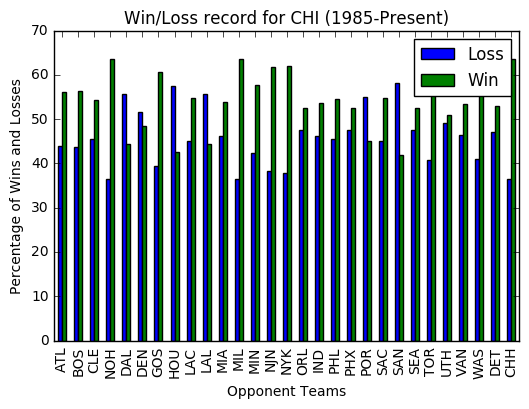

In [30]:
############ plot 1
# plot a bar graph of win/loss percentage of the team against all its opponent teams
df2 = pd.DataFrame(winLoss_records_byTeam[teamID][:,1:],columns=['Loss','Win'])
# print(df2['Loss'])
df2['Loss'] = (df2['Loss']/gameCount_ofTeam_byOpponent.tolist())*100
df2['Win'] = (df2['Win']/gameCount_ofTeam_byOpponent.tolist())*100
df3 = []
# get TEAM Abbreviations of the opponent teams for x-axis
for i in range(0,df2.index.size+1):
    if i != team_num:
        a = tm_id_nm[gameCount_byTeam.index.tolist()[i]][0]
        df3.append(a)
# change the idex of the dataframe to team abbreviation
df2.index = df3
df2.plot.bar()
plt.xlabel('Opponent Teams')
plt.ylabel('Percentage of Wins and Losses')
plt.title('Win/Loss record for '+team+' (1985-Present)')


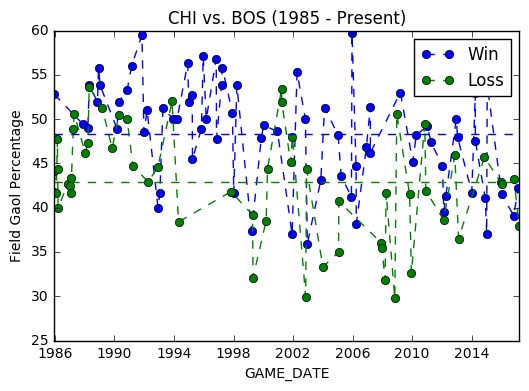

In [50]:
########### plot 2
# plot Field Goal percentages of the team against an opponent teams
OPP_WIN = data_for_team.loc[data_for_team['TEAM_ID'] == teamID].loc[data_for_team['OPPONENT_ID'] == oppTeamID].loc[data_for_team['WL'] == 1].sort_values('GAME_DATE')
OPP_LOSS = data_for_team.loc[data_for_team['TEAM_ID'] == teamID].loc[data_for_team['OPPONENT_ID'] == oppTeamID].loc[data_for_team['WL'] == 0].sort_values('GAME_DATE')
OPP_WIN_dates = mp.dates.date2num(pd.to_datetime(OPP_WIN['GAME_DATE']).tolist())
OPP_LOSS_dates = mp.dates.date2num(pd.to_datetime(OPP_LOSS['GAME_DATE']).tolist())

plt.figure(2)
plt.plot_date(OPP_WIN_dates,OPP_WIN['FG_PCT']*100,'o--')
plt.plot_date(OPP_LOSS_dates,OPP_LOSS['FG_PCT']*100,'o--')
plt.plot((np.min(OPP_WIN_dates),np.max(OPP_WIN_dates)),(OPP_WIN['FG_PCT'].mean()*100,OPP_WIN['FG_PCT'].mean()*100), 'b--')
plt.plot((np.min(OPP_LOSS_dates),np.max(OPP_LOSS_dates)),(OPP_LOSS['FG_PCT'].mean()*100,OPP_LOSS['FG_PCT'].mean()*100), 'g--')
plt.xlabel('GAME_DATE')
plt.ylabel('Field Gaol Percentage')
plt.title(team+' vs. '+oppTeam+' (1985 - Present)')
plt.legend(['Win','Loss'])
plt.show(block=False)

In [61]:
OPP_WIN.index.size

71

In [62]:
data_for_team[(data_for_team['WL']==1) & (data_for_team['OPPONENT_ID']==oppTeamID)].index.size

71

In [32]:
############################ Logistic regression

# prepare data for logistic regression
# X --> feature matrix
# y --> binary category (1 or 0)
X, y = prepare_data(df,teamID,oppTeamID)
#print X

In [64]:
X.shape

(126, 14)

In [34]:
# instantiate a Logistic regression model, and fit with X and y
lrModel = LogisticRegression()
lrModel = lrModel.fit(X,y)

In [35]:
# check the accuracy on the training set
print('')
print( '################# Logistic Regression report ####################')

# evaluate the model by splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
lrModel2 = LogisticRegression()
lrModel2.fit(X_train, y_train)

# predict class labels from the test set
predicted = lrModel2.predict(X_test)
print('')
print( 'Actual classes of the test data   : ', y_test)
print( '')
print( 'Predicted classes of the test data: ', predicted)
print( '')

# generate class probabilities
probs = lrModel2.predict_proba(X_test)
#print probs

cm = metrics.confusion_matrix(y_test, predicted)
print( 'Confusion matrix')
print( 'Class labels: 0     1')
print( '             ', cm[0][0], '  ', cm[0][1])
print( '             ', cm[1][0], '  ', cm[1][1])

print( '')
print( 'Classification report:')
print( metrics.classification_report(y_test, predicted))
print( '')

# evaluate the model using 10-fold cross-validation
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
scoring = 'accuracy'
scores = cross_val_score(LogisticRegression(), X, y, scoring=scoring, cv=kfold)
print('10-fold cross-validation accuracy: %.3f (%.3f)' % (scores.mean(), scores.std()))

# predicting the probability of winning
#features = np.array([1, 48, 86, 1, 2, 13, 27, 10, 27, 37, 13, 7, 20, 22])
#print lrModel.predict_proba(features.reshape(1,-1))


################# Logistic Regression report ####################

Actual classes of the test data   :  [1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1
 0]

Predicted classes of the test data:  [1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0 1
 1]

Confusion matrix
Class labels: 0     1
              15    3
              2    18

Classification report:
             precision    recall  f1-score   support

          0       0.88      0.83      0.86        18
          1       0.86      0.90      0.88        20

avg / total       0.87      0.87      0.87        38


10-fold cross-validation accuracy: 0.840 (0.107)
